# Project: Wrangling and Analyze Data

In [211]:
#Import all packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import json 
from IPython.display import HTML, display, Image
from IPython.core.display import HTML 
from functools import reduce
import seaborn as sns

In [2]:
! pip install tweepy

In [3]:
import tweepy
from tweepy import OAuthHandler

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [4]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [5]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [6]:
#URL downloaded programatically 
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

#Read TSV file
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

In [7]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [8]:
tweets = []
for line in open('tweet-json.txt', 'r'):
    tweets.append(json.loads(line))

In [9]:
with open('tweet_json_rev.txt', 'w') as file:
        file.write(json.dumps(tweets, indent=4))

In [10]:
my_list = []
with open('tweet_json_rev.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['full_text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(my_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])

In [11]:
tweet_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,39467,8853,3200889,104,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,33819,6514,3200889,104,Twitter for iPhone,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,25461,4328,3200889,104,Twitter for iPhone,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,42908,8964,3200889,104,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,41048,9774,3200889,104,Twitter for iPhone,Original tweet,https://t.co/AtUZn91f7f


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Visual assement
The data will be displayed to perform visual assement and get preliminary information about it.

In [12]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [13]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [14]:
tweet_json

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,39467,8853,3200889,104,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,33819,6514,3200889,104,Twitter for iPhone,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,25461,4328,3200889,104,Twitter for iPhone,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,42908,8964,3200889,104,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,41048,9774,3200889,104,Twitter for iPhone,Original tweet,https://t.co/AtUZn91f7f
...,...,...,...,...,...,...,...,...
2349,666049248165822465,111,41,3201018,104,Twitter for iPhone,Original tweet,https://t.co/4B7cOc1EDq
2350,666044226329800704,311,147,3201018,104,Twitter for iPhone,Original tweet,https://t.co/DWnyCjf2mx
2351,666033412701032449,128,47,3201018,104,Twitter for iPhone,Original tweet,https://t.co/y671yMhoiR
2352,666029285002620928,132,48,3201018,104,Twitter for iPhone,Original tweet,https://t.co/r7mOb2m0UI


### Porgramatic assement

In [13]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
sum(twitter_archive['tweet_id'].duplicated())

0

In [15]:
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [16]:
twitter_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [17]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

There are very high values in the numerator.

In [18]:
with pd.option_context('max_colwidth', 300):
    display(twitter_archive.query('rating_numerator== 351'))
    twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [19]:
with pd.option_context('max_colwidth', 300):
    display(twitter_archive.query('rating_numerator== 420')['expanded_urls'])

188                                                                 NaN
2074    https://twitter.com/dog_rates/status/670842764863651840/photo/1
Name: expanded_urls, dtype: object

So as it can be noticed some of this ourliers are empty or do not correspond with dog rates.

In [20]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

There are also outliers in the denominator, but after some analisys they seem to belong to proper dog rates correctly made.

In [21]:
with pd.option_context('max_colwidth', 300):
    display(twitter_archive.query('rating_denominator== 80'))

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80,80,None,None,None,None,None
1843,675853064436391936,NaN,NaN,2015-12-13 01:41:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/675853064436391936/photo/1,https://twitter.com/dog_rates/status/675853064436391936/photo/1",88,80,None,None,None,None,None


In [24]:
twitter_archive['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [22]:
with pd.option_context('max_colwidth', 200):
    display(twitter_archive[twitter_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Users\Jaime\AppData\Local\Temp/ipykernel_3192/1328960212.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  display(twitter_archive[twitter_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")]


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


It can be noticed that there are cases with decimal points in the numerator rating that have been stored properly in the rating_numerator variable.

In [23]:
(twitter_archive['timestamp']> "2017-08-01").value_counts()

False    2354
True        2
Name: timestamp, dtype: int64

Let's continue with the tweet image prediction

In [24]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
sum(image_prediction['tweet_id'].duplicated())

0

In [29]:
image_prediction['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [30]:
image_prediction['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [31]:
image_prediction['p2_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [ ]:
image_prediction['p3_dog'].value_counts()

In [26]:
# Getting the rows that their p1_dog, p2_dog and p3_dog is true at the same time
image_prediction.query('p1_dog== True and p2_dog==True and p3_dog== True')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [27]:
sum(image_prediction.jpg_url.duplicated())

66

In [28]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2354 non-null   object
 1   favorite_count    2354 non-null   int64 
 2   retweet_count     2354 non-null   int64 
 3   followers_count   2354 non-null   int64 
 4   friends_count     2354 non-null   int64 
 5   source            2354 non-null   object
 6   retweeted_status  2354 non-null   object
 7   url               2354 non-null   object
dtypes: int64(4), object(4)
memory usage: 147.2+ KB


In [35]:
tweet_json.source.value_counts()

Twitter for iPhone     2219
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

In [36]:
sum(tweet_json.tweet_id.duplicated())

0

In [37]:
tweet_json.retweeted_status.value_counts()

Original tweet       2175
This is a retweet     179
Name: retweeted_status, dtype: int64

## Quality issues to solve

### twitter_archive:
1.Only original ratings (no retweets) that have images will remain 

2.Delete columns that won't be used for analysis 

3.Erroneous datatypes (timestamp, rating_numerator and rating_denominator columns) 

4.Solve decimal point problem in numerator

5.Null value in column (name) registered as ("none") hence it do not show programatically as NaN.

6.Remove cases that do not correspond with dog ratings.


### image_prediction:
1.Drop 66 jpg_url duplicated

2.Delete columns that won't be used for analysis 

### tweet_json:
1.Correct the erroneous datatype for the column tweet_id

2.Keep original tweets only 


## Tidiness issues to solve

twitter_archive, image_prediction and tweet_json should be part of one dataset i.e. merged.

### twitter_archive:

1.Melt the columns of the dog stages (doggo, floofer, pupper, puppo) into one column (stages).

2.Create rating column, which contains the results of the rating_numerator divided by rating_denominator.

### image_prediction:

1.Create one column for the breed predictions and assign the values of the columns (p1, p2 and p3) to it. Then, delete p1, p2 and p3

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [158]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
image_prediction_clean = image_prediction.copy()
tweet_json_clean = tweet_json.copy()

### Quality issues - twitter_archive

### Issue #1: Keep only original ratings (no retweets) that have images 

#### Define:
As shown info of the twitter_archive dataset (assesment stage), there are 181 non-null values in the retweeted_status_id and retweeted_status_user_id columns that will have to be deleted.

#### Code

In [159]:
twitter_archive_clean= twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_user_id'])]

#### Test

In [160]:
sum(twitter_archive_clean.retweeted_status_user_id.value_counts())

0

In [161]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

### Issue #2: Delete columns that won't be used for analysis 

#### Define
Unnecesary columns for the analysis are deleted

#### Code

In [162]:
twitter_archive_clean.drop(['in_reply_to_status_id', 
                           'in_reply_to_user_id', 'source',
                           'retweeted_status_id', 
                           'retweeted_status_user_id', 
                           'retweeted_status_timestamp', 'expanded_urls'], 
                          axis=1, inplace=True)

#### Test

In [163]:
twitter_archive_clean.columns.values

array(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper',
       'puppo'], dtype=object)

### Issue #3: Erroneous datatypes (timestamp, rating_numerator and rating_denominator columns) 

#### Define
Column timestamp should be of type datetime. Columns rating_numerator and rating_denominator should be float since the operation applied on them is division.

#### Code

In [164]:
twitter_archive_clean['timestamp']= pd.to_datetime(twitter_archive_clean['timestamp']).dt.tz_localize(None)
twitter_archive_clean[['rating_numerator', 'rating_denominator']]=twitter_archive_clean[['rating_numerator', 'rating_denominator']].astype(float)

#### Test

In [165]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2175 non-null   int64         
 1   timestamp           2175 non-null   datetime64[ns]
 2   text                2175 non-null   object        
 3   rating_numerator    2175 non-null   float64       
 4   rating_denominator  2175 non-null   float64       
 5   name                2175 non-null   object        
 6   doggo               2175 non-null   object        
 7   floofer             2175 non-null   object        
 8   pupper              2175 non-null   object        
 9   puppo               2175 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 186.9+ KB


### Issue #4: Correct decimal point in rating_numerator. 

#### Define
There are numerator values that have a decimal point, and the code used to extract the numerator from the tweets only took the numbers after the decimal point as the numerator.

#### Code

In [166]:
decimal_numerator = twitter_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
twitter_archive_clean['rating_numerator'] = decimal_numerator[0]
twitter_archive_clean['rating_numerator']= twitter_archive_clean['rating_numerator'].astype(float)

#### Test

In [167]:
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\Jaime\AppData\Local\Temp/ipykernel_3192/2526864539.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]


,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,2017-07-08 00:28:19,This is Bella. She hopes her smile made you sm...,13.50,10.0,Bella,None,None,None,None
695,786709082849828864,2016-10-13 23:23:56,"This is Logan, the Chow who lived. He solemnly...",9.75,10.0,Logan,None,None,None,None
763,778027034220126208,2016-09-20 00:24:34,This is Sophie. She's a Jubilant Bush Pupper. ...,11.27,10.0,Sophie,None,None,pupper,None
1689,681340665377193984,2015-12-28 05:07:27,I've been told there's a slight possibility he...,9.50,10.0,None,None,None,None,None
1712,680494726643068929,2015-12-25 21:06:00,Here we have uncovered an entire battalion of ...,11.26,10.0,None,None,None,None,None


### Issue #5: Null value in column (name) 

#### Define
There are values registered as string('none') in the 'name' column, hence they do not show programatically as NaN.

#### Code

In [168]:
twitter_archive_clean['name'].replace('None', np.nan, inplace = True)

#### Test

In [169]:
twitter_archive_clean['name'].isnull().sum()

680

### Issue #6: Remove outliers

#### Define
Remove case of tweet not rating dogs or with outlier rating values

#### Code

In [173]:
twitter_archive_clean.drop(labels=2074, axis=0, inplace=True)
twitter_archive_clean.drop(labels=979, axis=0, inplace=True)
twitter_archive_clean.drop(labels=313, axis=0, inplace=True)
twitter_archive_clean.drop(labels=189, axis=0, inplace=True)
twitter_archive_clean.drop(labels=188, axis=0, inplace=True)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1120,731156023742988288,2016-05-13 16:15:54,Say hello to this unbelievably well behaved sq...,204.0,170.0,this,None,None,None,None
290,838150277551247360,2017-03-04 22:12:52,@markhoppus 182/10,182.0,10.0,NaN,None,None,None,None
902,758467244762497024,2016-07-28 01:00:57,Why does this never happen at my front door......,165.0,150.0,NaN,None,None,None,None
1779,677716515794329600,2015-12-18 05:06:23,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144.0,120.0,NaN,None,None,None,None
1634,684225744407494656,2016-01-05 04:11:44,"Two sneaky puppers were not initially seen, mo...",143.0,130.0,NaN,None,None,None,None
1635,684222868335505415,2016-01-05 04:00:18,Someone help the girl is being mugged. Several...,121.0,110.0,NaN,None,None,None,None
1228,713900603437621249,2016-03-27 01:29:02,Happy Saturday here's 9 puppers on a bench. 99...,99.0,90.0,NaN,None,None,None,None
1843,675853064436391936,2015-12-13 01:41:41,Here we have an entire platoon of puppers. Tot...,88.0,80.0,NaN,None,None,None,None
433,820690176645140481,2017-01-15 17:52:40,The floofs have been released I repeat the flo...,84.0,70.0,NaN,None,None,None,None
1254,710658690886586372,2016-03-18 02:46:49,Here's a brigade of puppers. All look very pre...,80.0,80.0,NaN,None,None,None,None


#### Test

In [176]:
twitter_archive_clean.query('tweet_id==749981277374128128')
twitter_archive_clean.query('tweet_id==835246439529840640')
twitter_archive_clean.query('tweet_id==855860136149123072')
twitter_archive_clean.query('tweet_id==670842764863651840')
twitter_archive_clean.query('tweet_id==855862651834028034')

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Quality issues - image_prediction

### Issue #1: Drop 66 jpg_url duplicated

#### Code

In [177]:
image_prediction_clean.drop_duplicates(subset=['jpg_url'], keep='last', inplace= True)

#### Test

In [178]:
sum(image_prediction_clean['jpg_url'].duplicated())

0

### Issue #2: Delete the columns that will not be used in the analysis.

#### Code

In [179]:
image_prediction_clean.drop(['img_num'], axis =1, inplace= True)

#### Test

In [180]:
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2009 non-null   int64  
 1   jpg_url   2009 non-null   object 
 2   p1        2009 non-null   object 
 3   p1_conf   2009 non-null   float64
 4   p1_dog    2009 non-null   bool   
 5   p2        2009 non-null   object 
 6   p2_conf   2009 non-null   float64
 7   p2_dog    2009 non-null   bool   
 8   p3        2009 non-null   object 
 9   p3_conf   2009 non-null   float64
 10  p3_dog    2009 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 147.1+ KB


### Quality issues - tweet_json

### Issue #1: Correct the erroneous datatype for the column tweet_id

#### Code

In [181]:
tweet_json_clean['tweet_id']= tweet_json_clean['tweet_id'].astype(np.int64)

#### Test

In [182]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2354 non-null   int64 
 1   favorite_count    2354 non-null   int64 
 2   retweet_count     2354 non-null   int64 
 3   followers_count   2354 non-null   int64 
 4   friends_count     2354 non-null   int64 
 5   source            2354 non-null   object
 6   retweeted_status  2354 non-null   object
 7   url               2354 non-null   object
dtypes: int64(5), object(3)
memory usage: 147.2+ KB


### Issue #2: Keep original tweets only  

#### Code

In [183]:
tweet_json_clean = tweet_json_clean[tweet_json_clean['retweeted_status'] == 'Original tweet']

#### Test

In [184]:
tweet_json_clean['retweeted_status'].value_counts()

Original tweet    2175
Name: retweeted_status, dtype: int64

### Tidiness issues - twitter_archive

### Issue #1: Melt the columns of the dog stages (doggo, floofer, pupper, puppo) into one column (dog_stages).

#### Code

In [185]:
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars=['tweet_id','timestamp','text','rating_numerator','rating_denominator', 'name'],
                               var_name='stages', value_name='dog_stages')

twitter_archive_clean = twitter_archive_clean.drop('stages', axis= 1)

twitter_archive_clean = twitter_archive_clean.sort_values('dog_stages').drop_duplicates(subset='tweet_id', keep='last')

#### Test

In [186]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 2091 to 7061
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2170 non-null   int64         
 1   timestamp           2170 non-null   datetime64[ns]
 2   text                2170 non-null   object        
 3   rating_numerator    2170 non-null   float64       
 4   rating_denominator  2170 non-null   float64       
 5   name                1494 non-null   object        
 6   dog_stages          2170 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 135.6+ KB


### Issue #2: Create rating column, which contains the results of the rating_numerator divided by rating_denominator.

#### Code

In [187]:
twitter_archive_clean['rating'] = 10 * twitter_archive_clean['rating_numerator'] / twitter_archive_clean['rating_denominator']

#### Test

In [188]:
twitter_archive_clean[['rating']].head(10)

,rating
2091,10.0
2090,6.0
2089,11.0
2088,7.0
2087,11.0
2086,7.0
2085,9.0
2084,11.0
2083,12.0
2082,8.0


### Tidiness issues - image_prediction

### Issue #1: Create one column for the breed predictions and assign the values of the columns (p1, p2 and p3) to it

#### Code

In [189]:
def BreedPred(p):
    if p['p1_dog']:
        return(p['p1'])
    elif p['p2_dog']:
        return(p['p2'])
    elif p['p3_dog']:
        return(p['p3'])
    else:
        return(np.NaN)
    

def PredictionConf(pc):
    if pc['p1_dog']:
        return(pc['p1_conf'])
    elif pc['p2_dog']:
        return(pc['p2_conf'])
    elif pc['p3_dog']:
        return(pc['p3_conf'])
    else:
        return(np.NaN)
    
image_prediction_clean['breed_prediction'] = image_prediction_clean.apply (lambda p: BreedPred (p),axis=1)
image_prediction_clean['prediction_confidence'] = image_prediction_clean.apply (lambda pc: PredictionConf(pc), axis= 1)

image_prediction_clean.drop(['p1', 'p2', 'p3', 'p1_conf', 'p2_conf', 'p3_conf', 'p1_dog', 'p2_dog', 'p3_dog'], axis= 1, inplace= True)

#### Test

In [190]:
image_prediction_clean.head(15)

,tweet_id,jpg_url,breed_prediction,prediction_confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,0.651137
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,NaN,NaN
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,0.692517
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,golden_retriever,0.007959
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,miniature_poodle,0.201493


### Tidiness issues - general

### Issue: Merge all data sources into one dataframe

#### Code

In [191]:
datasets = [twitter_archive_clean, image_prediction_clean, tweet_json_clean]
twitter_archive_final = reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), datasets)

#### Test

In [192]:
twitter_archive_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 1925
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1926 non-null   int64         
 1   timestamp              1926 non-null   datetime64[ns]
 2   text                   1926 non-null   object        
 3   rating_numerator       1926 non-null   float64       
 4   rating_denominator     1926 non-null   float64       
 5   name                   1398 non-null   object        
 6   dog_stages             1926 non-null   object        
 7   rating                 1926 non-null   float64       
 8   jpg_url                1926 non-null   object        
 9   breed_prediction       1626 non-null   object        
 10  prediction_confidence  1626 non-null   float64       
 11  favorite_count         1926 non-null   int64         
 12  retweet_count          1926 non-null   int64         
 13  fol

In [193]:
twitter_archive_final.head(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stages,rating,jpg_url,breed_prediction,prediction_confidence,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,667437278097252352,2015-11-19 20:20:22,Never seen this breed before. Very pointy pup....,10.0,10.0,NaN,None,10.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,NaN,NaN,483,257,3201016,104,Twitter for iPhone,Original tweet,https://t.co/97HuBrVuOx
1,667443425659232256,2015-11-19 20:44:47,Exotic dog here. Long neck. Weird paws. Obsess...,6.0,10.0,NaN,None,6.0,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,NaN,NaN,833,620,3201016,104,Twitter for iPhone,Original tweet,https://t.co/rqO4I3nf2N
2,667453023279554560,2015-11-19 21:22:56,Meet Cupcake. I would do unspeakable things fo...,11.0,10.0,Cupcake,None,11.0,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,Labrador_retriever,0.825670,327,96,3201016,104,Twitter Web Client,Original tweet,https://t.co/6uLCWR9Efa
3,667455448082227200,2015-11-19 21:32:34,This is Reese and Twips. Reese protects Twips....,7.0,10.0,Reese,None,7.0,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,Tibetan_terrier,0.676376,203,66,3201016,104,Twitter Web Client,Original tweet,https://t.co/uLzRi1drVK
4,667470559035432960,2015-11-19 22:32:36,This is a northern Wahoo named Kohl. He runs t...,11.0,10.0,a,None,11.0,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,toy_poodle,0.304175,273,102,3201016,104,Twitter Web Client,Original tweet,https://t.co/J4vn2rOYFk
5,667491009379606528,2015-11-19 23:53:52,Two dogs in this one. Both are rare Jujitsu Py...,7.0,10.0,NaN,None,7.0,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,borzoi,0.852088,559,242,3201016,104,Twitter Web Client,Original tweet,https://t.co/ITxxcc4v9y
6,667495797102141441,2015-11-20 00:12:54,This is Philippe from Soviet Russia. Commandin...,9.0,10.0,Philippe,None,9.0,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,Chihuahua,0.143957,565,294,3201016,104,Twitter Web Client,Original tweet,https://t.co/5NhPV8E45i
7,667502640335572993,2015-11-20 00:40:05,Say hello to Hall and Oates. Oates is winking ...,11.0,10.0,Hall,None,11.0,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,Labrador_retriever,0.996709,563,231,3201016,104,Twitter Web Client,Original tweet,https://t.co/n5Wtb5Hvsl
8,667517642048163840,2015-11-20 01:39:42,This is Dook &amp; Milo. Dook is struggling to...,8.0,10.0,Dook,None,8.0,https://pbs.twimg.com/media/CUN_wiBUkAAakT0.jpg,Italian_greyhound,0.125176,389,203,3201016,104,Twitter Web Client,Original tweet,https://t.co/fh5KflzBR0
9,667524857454854144,2015-11-20 02:08:22,Another topnotch dog. His name is Big Jumpy Ra...,12.0,10.0,NaN,None,12.0,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,Chesapeake_Bay_retriever,0.088122,1798,1198,3201016,104,Twitter Web Client,Original tweet,https://t.co/seESNzgsdm


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [194]:
twitter_archive_final.to_csv('twitter_archive_final.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

## Insights and visualization

### Insight 1
In this section will be analized and plotted the relation betweeen the number of retweets and the rating received. 

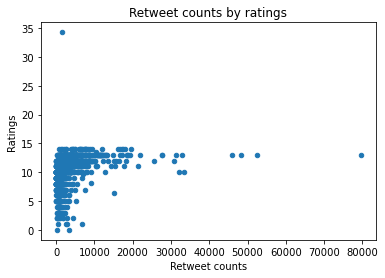

In [201]:
twitter_archive_final.plot(x='retweet_count', y='rating', kind='scatter')
plt.xlabel('Retweet counts')
plt.ylabel('Ratings')
plt.title('Retweet counts by ratings')

fig = plt.gcf()

So although dispersion is relevant, there are more cases of high number of retweets when the rating received is high. 

### Insight 2
In this section will be analized and plotted the relation between the number of retweets and likes

Text(-0.5437499999999957, 0.5, 'Number of likes')

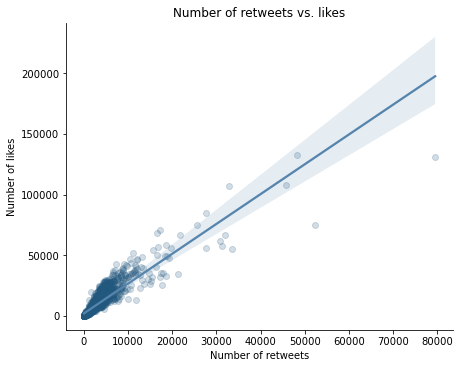

In [217]:
colors = ["#5584AC"]
sns.set_palette(sns.color_palette(colors))
sns.lmplot(x="retweet_count", 
           y="favorite_count", 
           data=twitter_archive_final,
           height = 5,
           aspect=1.3,
           scatter_kws={'alpha':1/5, "color": "#22577E"})
plt.title('Number of retweets vs. likes')
plt.xlabel('Number of retweets')
plt.ylabel('Number of likes')

So it can be noticed that there is a clear direct relation between number of retweets and number of likes received.

### Insight 3
In this section will be analized and plotted the top twenty most frequent types of dogs predicted by the neural network and the confidence interval of the top ten most frequent dogs predicted.

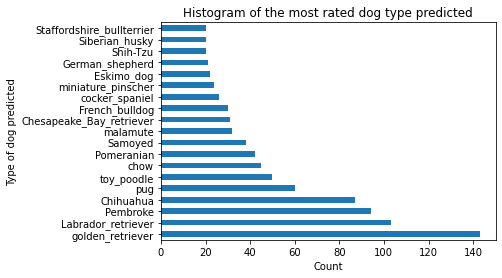

In [209]:
df_dog = twitter_archive_final.groupby('breed_prediction').filter(lambda x: len(x) >= 20)

df_dog['breed_prediction'].value_counts().plot(kind = 'barh')
plt.title('Histogram of the most rated dog type predicted')
plt.xlabel('Count')
plt.ylabel('Type of dog predicted')

fig = plt.gcf() 

So as it can be noticed, the most common dogs predicted are Golden Retriever, Labrador Retriever and Pembroke.

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

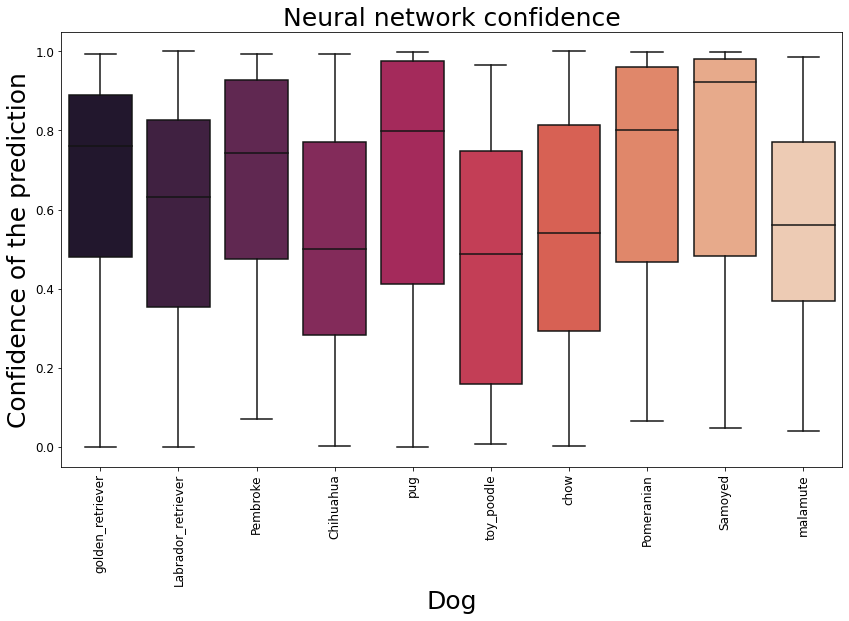

In [254]:
frequent= twitter_archive_final['breed_prediction'].value_counts()[0:10].index.tolist()
cinterval= twitter_archive_final[twitter_archive_final['breed_prediction'].isin(frequent)]
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
sns.boxplot(x='breed_prediction', y='prediction_confidence', data=cinterval, order=frequent, palette="rocket", ax=ax)
plt.title('Neural network confidence', size=25)
plt.xlabel('Dog',size=25)
plt.ylabel('Confidence of the prediction',size=25)
plt.xticks(fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.yticks(fontsize=12)

So as it can be seen confidence intervals of dogs predicted have relevant variatons, being Pug and Samoyed the ones with higher median.

### Insight 4
In this section will be analized and plotted the most frequent dog stage (doggo, floofer, pupper, puppo) 

(array([0, 1, 2, 3]),
 [Text(0, 0, 'doggo'),
  Text(1, 0, 'floofer'),
  Text(2, 0, 'pupper'),
  Text(3, 0, 'puppo')])

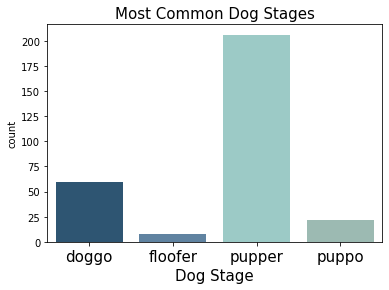

In [242]:
color2 = ["#22577E","#5584AC","#95D1CC","#97BFB4"]
sns.set_palette(sns.color_palette(color2))
color=sns.countplot(data=twitter_archive_final.loc[twitter_archive_final['dog_stages'] !='None']['dog_stages'], x=twitter_archive_final.loc[twitter_archive_final['dog_stages'] !='None']['dog_stages'])
plt.title('Most Common Dog Stages', size=15)
plt.xlabel('Dog Stage',size=15)
plt.xticks(fontsize=15)

So pupper is clearly the most frequent dog stage as it appears 206 times in the dataset.